# Data Cleaning and Exploratory Data Analysis

Author: Kaveri Chhikara

In [2]:
from pyspark.sql import SparkSession,Row
from pyspark.sql.functions import *
from pyspark.sql.window import Window
# import sparknlp
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd

In [3]:
#print spark configuration settings
# sparknlp.start()
spark = SparkSession.builder.appName('CitationNetworkAnalysisV12').getOrCreate()
# spark = SparkSession.builder.appName('CitationNetworkAnalysis').master('local').config("spark.executor.memory", "3g").getOrCreate()
spark.sparkContext.getConf().getAll()

[('spark.eventLog.enabled', 'true'),
 ('spark.dynamicAllocation.minExecutors', '1'),
 ('spark.dataproc.sql.parquet.enableFooterCache', 'true'),
 ('spark.sql.warehouse.dir', 'file:/spark-warehouse'),
 ('spark.dataproc.sql.joinConditionReorder.enabled', 'true'),
 ('spark.ui.proxyBase', '/proxy/application_1678082267476_0015'),
 ('spark.executor.memory', '12859m'),
 ('spark.yarn.am.memory', '640m'),
 ('spark.executor.cores', '4'),
 ('spark.dataproc.sql.local.rank.pushdown.enabled', 'true'),
 ('spark.driver.port', '39375'),
 ('spark.driver.appUIAddress',
  'http://cluster-39d1-m.c.msca-bdp-student-ap.internal:39777'),
 ('spark.executor.instances', '2'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.yarn.unmanagedAM.enabled', 'true'),
 ('spark.history.fs.logDirectory',
  'gs://dataproc-temp-us-central1-635155370842-uzamlpgc/0683fb4b-e3ba-49e7-8c10-185ed2f701af/spark-job-history'),
 ('spark.driver.memory', '16384m'),
 ('spark.submit.deployMode', 'client'),
 ('spark.extraListeners'

In [4]:
# Import Data
# "msca-bdp-student-gcs/Group5_Final_Project/raw_data/dblp.v12.json"
raw_data = "gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/dblp_v14.json"

In [5]:
df = spark.read.json(raw_data)

In [5]:
df.printSchema()

root
 |-- _corrupt_record: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- authors: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: string (nullable = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- org: string (nullable = true)
 |-- doc_type: string (nullable = true)
 |-- doi: string (nullable = true)
 |-- fos: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- name: string (nullable = true)
 |    |    |-- w: double (nullable = true)
 |-- id: string (nullable = true)
 |-- indexed_abstract: string (nullable = true)
 |-- isbn: string (nullable = true)
 |-- issn: string (nullable = true)
 |-- issue: string (nullable = true)
 |-- keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- lang: string (nullable = true)
 |-- n_citation: long (nullable = true)
 |-- page_end: string (nullable = true)
 |-- page_start: string (nullable = true)
 |-- 

In [6]:
df_clean = df.select(df.id, df.fos[0].getItem('name'),
                     df.doc_type,
                     df.authors[0].getItem('name'),
                     df.authors[0].getItem('id'),
                     df.authors[0].getItem('org'),
                     df.abstract, df.title, df.year, 
                     df.n_citation, df.references,
                     df.keywords)

In [7]:
df_clean = df_clean.withColumnRenamed("fos[0].name","category")\
                .withColumnRenamed("authors[0].name","author_name")\
                .withColumnRenamed("authors[0].org","author_org")\
                .withColumnRenamed("authors[0].id","author_id")\
                .withColumnRenamed("id","paper_id")

In [8]:
# dropping rows with na in any column
df_new = df_clean.na.drop()

## Descriptive statistics

* `paper_id` is a string variable to uniquely identify each paper. Similarly, author_id is used to identify an author. 
* `references` is the list of paper_ids that cited that paper. n_citations is the count of that list. Explore that this is the same.
* `category` is the field of study that paper belongs to
* `author_org` is the organization the author associates with at the time of publishing the paper. There are duplicates in this column, for instance Carnegie Mellon University, Pittsburgh, PA, USA, Carnegie Mellon University, Pittsburgh, PA, Carnegie Mellon University, Carnegie Mellon Univ, Pittsburgh, PA 15213 USA are all different entries while they should be the same. I have cleaned this column using regular expression and reduced the number of unique entries from 
* `year` denotes the year of publication. The dataset contains papers from 1953 to 2022
* 

In [9]:
df_new.describe().toPandas()

,summary,paper_id,category,doc_type,author_name,author_id,author_org,abstract,title,year,n_citation
0,count,3016963,3016963,3016963,3016963,3016963,3016963,3016963,3016963,3016963,3016963
1,mean,Infinity,NaN,None,NaN,None,1.0,2.286105E7,None,2008.4213488862806,32.36902308712437
2,stddev,NaN,NaN,None,None,None,None,1.2942132812268652E7,None,8.207315941903783,270.3740997947502
3,min,53e99784b7602d9701f3e151,#SAT,Conference,,,,,H−∕H∞ fault detection observer in fin...,1936,0
4,max,5f35115491e011e2b713e0bb,σ-finite measure,Journal,�scar Lopez,63bbd191163be4f513f4ad8e,﻿ICBAS–Instituto de Ciências Biomédicas de Abe...,�� �� Abstract - The main concept of design an...,𝕃1 adaptive networked controller for islanded ...,2022,149359


### Creating the number of references column from the array of references column

In [9]:
# // size of ArrayType & MapType columns
# df_new.select("references").show(n=100)
df_new = df_new.withColumn("n_references",size(col("references")))

In [11]:
df_new.describe().toPandas()

,summary,paper_id,category,doc_type,author_name,author_id,author_org,abstract,title,year,n_citation,n_references
0,count,3016963,3016963,3016963,3016963,3016963,3016963,3016963,3016963,3016963,3016963,3016963
1,mean,Infinity,NaN,None,NaN,None,1.0,2.286105E7,None,2008.4213488862806,32.36902308712437,10.05699572716006
2,stddev,NaN,NaN,None,None,None,None,1.2942132812268652E7,None,8.207315941903792,270.3740997947502,12.587514797049284
3,min,53e99784b7602d9701f3e151,#SAT,Conference,,,,,H−∕H∞ fault detection observer in fin...,1936,0,0
4,max,5f35115491e011e2b713e0bb,σ-finite measure,Journal,�scar Lopez,63bbd191163be4f513f4ad8e,﻿ICBAS–Instituto de Ciências Biomédicas de Abe...,�� �� Abstract - The main concept of design an...,𝕃1 adaptive networked controller for islanded ...,2022,149359,2294


### Cleaning Abstract column

A number of entries in the abstract column are blanks, nulls, "No Abstract available" etc.
We only keep entries where the asbtracts are unique to avoid papers with duplicate abstracts.

In [12]:
df_new.groupBy('abstract').count().orderBy('count', ascending = False).show()

+--------------------+------+
|            abstract| count|
+--------------------+------+
|                    |297803|
|    Without Abstract|  3789|
|No abstract avail...|  1247|
|First Page of the...|   705|
|No abstract avail...|   194|
|            Abstract|   132|
|                    |   132|
|Use the "Report a...|   109|
|

An abstract is ...|    92|
|Ohne Zusammenfassung|    87|
|Through the past ...|    87|
|All over the worl...|    74|
|Service Level Agr...|    60|
|There are plenty ...|    56|
|Start of the abov...|    55|
|OGSA-DAI provides...|    54|
|Speculative execu...|    54|
|Evolutionary mult...|    49|
|                  : |    45|
|Online auctions h...|    44|
+--------------------+------+
only showing top 20 rows



In [10]:
#removing rows where abstract is empty
df_read = df_new.filter("abstract != ''")
df_read = df_read.filter(trim(col("abstract")) != "null")
#remove all the abstracts which are duplicate
abstracts_to_remove = df_read.groupBy("abstract").count().orderBy(col("count")).filter(col("count")>1)
abstracts_remove_list = abstracts_to_remove.rdd.map(lambda x: x[0]).collect()
df_read = df_read.filter(~df_read.abstract.isin(abstracts_remove_list))
#trim whitespace
df_read = df_read.withColumn("abstract", trim(df.abstract))
#remove redundant space between words
df_read = df_read.withColumn("abstract", regexp_replace("abstract", "\s+", " "))
#remove punctuation marks
df_read = df_read.withColumn("abstract", regexp_replace("abstract", "[^\\w\\s]+", ""))

In [11]:
#removing rows where abstract is empty in case we end up with a few after removing redundant spaces and punctuations
df_read = df_new.filter("abstract != ''")

In [15]:
df_read.describe().toPandas()

,summary,paper_id,category,doc_type,author_name,author_id,author_org,abstract,title,year,n_citation,n_references
0,count,2719160,2719160,2719160,2719160,2719160,2719160,2719160,2719160,2719160,2719160,2719160
1,mean,Infinity,NaN,None,NaN,None,1.0,2.286105E7,None,2008.8892323364569,34.0544451227585,10.571949793318526
2,stddev,NaN,None,None,None,None,None,1.2942132812268652E7,None,7.796624847219174,278.3349558304617,12.867371916102554
3,min,53e99784b7602d9701f3f411,#SAT,Conference,,,,\n,H−∕H∞ fault detection observer in fin...,1946,0,0
4,max,5f35115491e011e2b713e0bb,σ-finite measure,Journal,�scar Lopez,63bbd191163be4f513f4ad8e,﻿ICBAS–Instituto de Ciências Biomédicas de Abe...,�� �� Abstract - The main concept of design an...,𝕃1 adaptive networked controller for islanded ...,2022,149359,2294


### Distribution of papers over the years

Majority of the papers published in the dataset are from 1990-2020. So, we create a subset of this dataset for our analysis. 

In [32]:
# count of papers in each category- DO NOT RUN AGAIN
year_counts = df_read.groupBy("year").count().orderBy('year', ascending = True).toPandas()

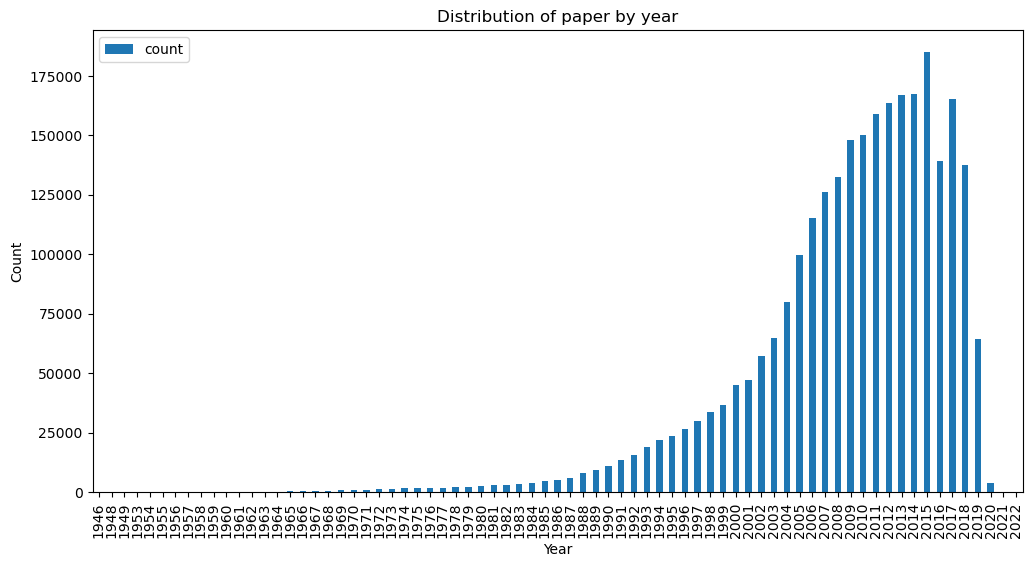

In [36]:
# Create a bar plot of the year_counts dataframe
year_counts.plot(kind="bar", x="year", y="count", figsize=(12, 6))

# Add labels and title
plt.xlabel("Year")
plt.ylabel("Count")
plt.title("Distribution of paper by year")

# Display the plot
plt.show()

In [12]:
df_subset = df_read.filter((df_read['year'] >= 1990) & (df_read['year'] <= 2020) )

In [38]:
df_subset.select('year').describe().show()

+-------+------------------+
|summary|              year|
+-------+------------------+
|  count|           2649741|
|   mean|2009.5911649478194|
| stddev| 6.476476877154237|
|    min|              1990|
|    max|              2020|
+-------+------------------+



## Categories over the years

In [53]:
# count of papers in each category- DO NOT RUN AGAIN
category_counts = df_subset.groupBy("category").count().orderBy('count', ascending = False).toPandas()

In [53]:
# category_counts.iloc[31000:31087]
# category_counts.head(50)

,category,count
0,Computer vision,120195
1,Data mining,103029
2,Computer science,87324
3,Discrete mathematics,80942
4,Mathematical optimization,64735
5,Convergence (routing),29736
6,Information system,24512
7,Data science,23061
8,World Wide Web,22679
9,Mobile computing,18023


In [54]:
# !pip install wordcloud

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 459.0/459.0 kB 9.6 MB/s eta 0:00:00a 0:00:01


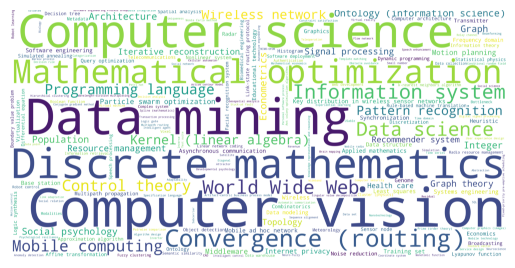

<Figure size 8000x4000 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [57]:
# !pip install wordcloud
#bag of words
from wordcloud import WordCloud
# Convert the dataframe to a dictionary
category_dict = dict(zip(category_counts['category'], category_counts['count']))
# Create a WordCloud object with the desired settings
wordcloud = WordCloud(width=8000, height=4000, background_color='white').generate_from_frequencies(category_dict)

# Display the word cloud using matplotlib
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.figure( figsize=(80,40) )
plt.show()
plt.savefig('word_cloud.png')

In [59]:
# count of papers in each category by year
category_counts_by_year = df_subset.groupBy("category", "year").count().orderBy('count', ascending = False)

In [60]:
# Define the window function
w = Window.partitionBy('Year').orderBy(col('count').desc())
# Use the rank function to get the top 5 values for each year
top5_categories = category_counts_by_year.select('*', rank().over(w).alias('rank')).filter(col('rank') <= 5).drop('rank')

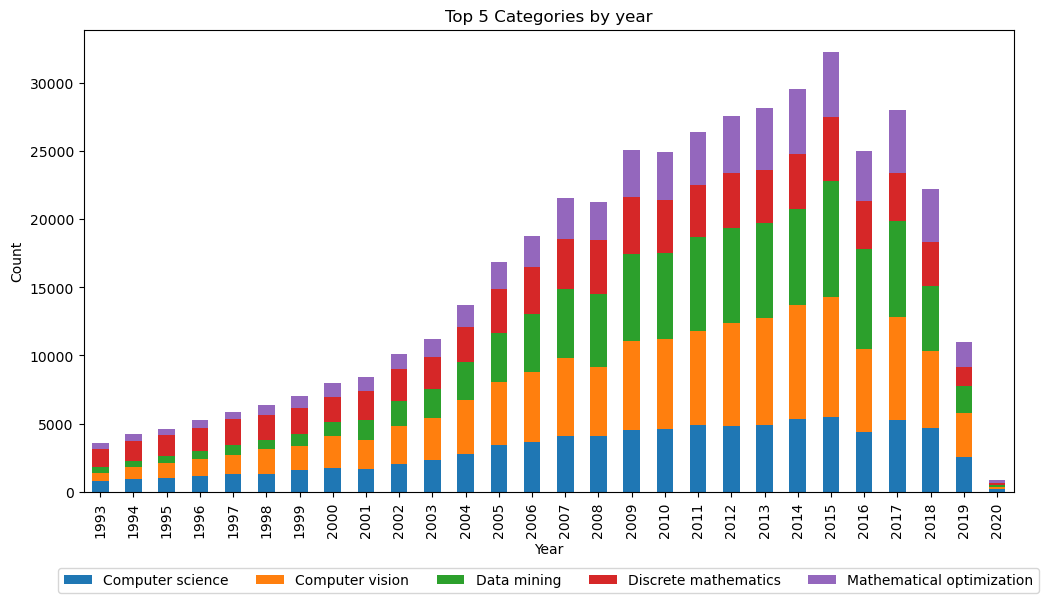

In [61]:
# Transpose the data to switch the x-axis and legend
top5_categories_pivot = top5_categories.filter((top5_categories['year'] > 1992)&(top5_categories['year'] < 2021)).toPandas().pivot(index='year', columns='category', values='count')
ax = top5_categories_pivot.plot(kind='bar', stacked=True, figsize=(12, 6), xlabel = 'Year',ylabel = 'Count',title = 'Top 5 Categories by year')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=5)

## Document types

There are just two types of documents in the dataset- conference and journals

In [63]:
df_subset.groupBy("doc_type").agg(count("doc_type").alias("count")).show()

+----------+-------+
|  doc_type|  count|
+----------+-------+
|Conference|1450066|
|   Journal|1199675|
+----------+-------+



In [62]:
df_subset.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- doc_type: string (nullable = true)
 |-- author_name: string (nullable = true)
 |-- author_id: string (nullable = true)
 |-- author_org: string (nullable = true)
 |-- abstract: string (nullable = true)
 |-- title: string (nullable = true)
 |-- year: long (nullable = true)
 |-- n_citation: long (nullable = true)
 |-- references: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- keywords: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- n_references: integer (nullable = false)



## Writing clean dataset to a csv on Bucket

In [69]:
# df_write_csv = df_subset.select('paper_id', 'category', 'doc_type', 'year','abstract','title', 'n_citation', 'n_references')
# df_write_csv.write.option("header",True) \
#  .csv("gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/clean_data_march5_v2.csv")

In [12]:
# df_write_csv.repartition(1).write.option("header",True).json("gs://msca-bdp-student-gcs/Group5_Final_Project/raw_data/clean_data_march5_nopartition.json")

## Graphs

In [18]:
print("Number of rows in the dataset", df_subset.count())

Number of rows in the dataset 2649741


After cleaning the dataset, we are left with 2.6 million observations.

In [70]:
# !pip3 install graphframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 5.7 MB/s eta 0:00:00


In [13]:
df_graph = df_subset.select('paper_id', 'category', 'doc_type', 'year', 'title', 'references', 'n_references')
df_graph = df_graph.withColumn("reference", explode(df.references)).withColumn("weight", lit(1))

In [14]:
df_graph.show(n=2, truncate=False)

+------------------------+--------------+--------+----+------------------------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+------------------------+------+
|paper_id                |category      |doc_type|year|title                                                                                                             |references                                                                                                                                                                                                                                |n_references|reference               |weight|
+------------------------+--------------+--------+----+-------------------------------------------

In [22]:
print("Number of rows in the graph dataset", df_graph.count())

Number of rows in the graph dataset 28380157


The number of observations has increased from 2649741 to 28380157 after creating a column with each combination of the paper and its references

In [23]:
df_graph.printSchema()

root
 |-- paper_id: string (nullable = true)
 |-- category: string (nullable = true)
 |-- doc_type: string (nullable = true)
 |-- year: long (nullable = true)
 |-- title: string (nullable = true)
 |-- references: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- n_references: integer (nullable = false)
 |-- reference: string (nullable = true)
 |-- weight: integer (nullable = false)



In [15]:
dfm = df_graph.groupby(df_graph.paper_id,df_graph.reference, df_graph.category).count()
dfm = dfm[dfm['paper_id'] != dfm['reference']]
paper1 = dfm.select("paper_id").distinct().toDF("id")
paper2 = dfm.select("reference").distinct().toDF("id")
papers = paper1.unionAll(paper2).distinct().cache()
dfm = dfm.withColumnRenamed("paper_id", "src").withColumnRenamed("reference", "dst")

In [27]:
# !pip install graphframes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 6.3 MB/s eta 0:00:00


In [16]:
from graphframes import *
g = GraphFrame(papers, dfm)

In [17]:
# graph vertices
g.vertices.show()

+--------------------+
|                  id|
+--------------------+
|53e9ae0bb7602d970...|
|53e9ae36b7602d970...|
|53e9ae49b7602d970...|
|53e9aec4b7602d970...|
|53e9aed7b7602d970...|
|53e9aed8b7602d970...|
|53e9aeeab7602d970...|
|53e9af26b7602d970...|
|53e9af4cb7602d970...|
|53e9af81b7602d970...|
|53e9af94b7602d970...|
|53e9afa0b7602d970...|
|53e9afb3b7602d970...|
|53e9afb3b7602d970...|
|53e9b017b7602d970...|
|5a260c5d17c44a4ba...|
|5a260c5d17c44a4ba...|
|5a260c5d17c44a4ba...|
|5a260c6117c44a4ba...|
|5a260c6917c44a4ba...|
+--------------------+
only showing top 20 rows



In [18]:
## Check the number of edges of each vertex
g.degrees.orderBy('degree', ascending=False).show()

+--------------------+------+
|                  id|degree|
+--------------------+------+
|53e9986eb7602d970...|  9126|
|53e9a95db7602d970...|  8224|
|53e9b61bb7602d970...|  7338|
|53e9bcc1b7602d970...|  6666|
|53e9a690b7602d970...|  6634|
|558b149de4b0b32fc...|  6299|
|53e9b48fb7602d970...|  6261|
|53e9b47cb7602d970...|  6207|
|53e99931b7602d970...|  5747|
|53e9bb52b7602d970...|  5602|
|53e9b587b7602d970...|  5596|
|53e9afe8b7602d970...|  5324|
|53e9a533b7602d970...|  5131|
|53e9a281b7602d970...|  4965|
|53e9ad33b7602d970...|  4746|
|53e9a9d3b7602d970...|  4711|
|53e9a1dbb7602d970...|  4664|
|573696026e3b12023...|  4609|
|573696a36e3b12023...|  4545|
|5550415645ce0a409...|  4516|
+--------------------+------+
only showing top 20 rows



In [19]:
#The outgoing degree of the vertices
g.outDegrees.orderBy('outDegree', ascending=False).show()

+--------------------+---------+
|                  id|outDegree|
+--------------------+---------+
|53e9b5c8b7602d970...|     2292|
|53e99fe4b7602d970...|     1929|
|53e9b253b7602d970...|     1752|
|53e9a018b7602d970...|     1682|
|5550400e45ce0a409...|     1179|
|5550438f45ce0a409...|     1151|
|53e9a5e2b7602d970...|     1146|
|53e9ab89b7602d970...|     1138|
|53e9b0dfb7602d970...|     1041|
|573696716e3b12023...|      972|
|55503f9f45ce0a409...|      964|
|53e99e21b7602d970...|      873|
|55503fe145ce0a409...|      818|
|53e9b221b7602d970...|      763|
|5550435345ce0a409...|      749|
|53e9a9dfb7602d970...|      747|
|573695b96e3b12023...|      742|
|56d9106cdabfae2ee...|      742|
|599c7963601a182cd...|      740|
|53e9a782b7602d970...|      733|
+--------------------+---------+
only showing top 20 rows



In [20]:
referenceCount = g.edges.groupBy("src", "dst").count().orderBy("count", ascending = False)
referenceCount.show()

+--------------------+--------------------+-----+
|                 src|                 dst|count|
+--------------------+--------------------+-----+
|53e99d28b7602d970...|53e9a1c3b7602d970...|    1|
|53e99d36b7602d970...|53e9a5afb7602d970...|    1|
|53e99d6cb7602d970...|53e99b16b7602d970...|    1|
|53e99d9db7602d970...|53e9a089b7602d970...|    1|
|53e99d9eb7602d970...|53e9ba22b7602d970...|    1|
|53e99d36b7602d970...|53e9b37bb7602d970...|    1|
|53e99d36b7602d970...|53e997f1b7602d970...|    1|
|53e99d51b7602d970...|53e9baa7b7602d970...|    1|
|53e99d65b7602d970...|53e9a8beb7602d970...|    1|
|53e99d74b7602d970...|53e9b1a3b7602d970...|    1|
|53e99d80b7602d970...|53e9b7c1b7602d970...|    1|
|53e99d96b7602d970...|53e9af06b7602d970...|    1|
|53e99d36b7602d970...|53e9ad42b7602d970...|    1|
|53e99d44b7602d970...|53e99a85b7602d970...|    1|
|53e99d65b7602d970...|53e9b6d1b7602d970...|    1|
|53e99d65b7602d970...|53e99b6ab7602d970...|    1|
|53e99d81b7602d970...|53e99ce0b7602d970...|    1|


Take a subset of this data, Let's start by focusing on one category for the graph. I have taken Computer Vision here

## Graph Visualization for a subset of data

## Economics data

In [21]:
# !pip install --upgrade scipy networkx 

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 45.7 MB/s eta 0:00:0000:0100:01
  Attempting uninstall: scipy
    Found existing installation: scipy 1.6.3
    Uninstalling scipy-1.6.3:
      Successfully uninstalled scipy-1.6.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pointpats 2.2.0 requires opencv-contrib-python>=4.2.0, which is not installed.
pysal 2.4.0 requires urllib3>=1.26, but you have urllib3 1.25.11 which is incompatible.


In [25]:
df_graph_econ = df_graph.filter(df_graph['category']== 'Economics')
dfm = df_graph_econ.groupby(df_graph.paper_id,df_graph.reference).count()
dfm = dfm[dfm['paper_id'] != dfm['reference']]
dfm = dfm.withColumnRenamed("paper_id", "src").withColumnRenamed("reference", "dst")

In [ ]:
dfm_pd = dfm.toPandas()

In [28]:
# create a directed-graph from a dataframe
def plotGraph(pdf):
    G=nx.from_pandas_edgelist(pdf[:350], "src", "dst", 
                              edge_attr=True, create_using=nx.MultiDiGraph())
    counts = [i['count'] for i in dict(G.edges).values()]

    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=False, node_color='skyblue', width=counts, edge_cmap=plt.cm.Blues, pos = pos)
    plt.show()

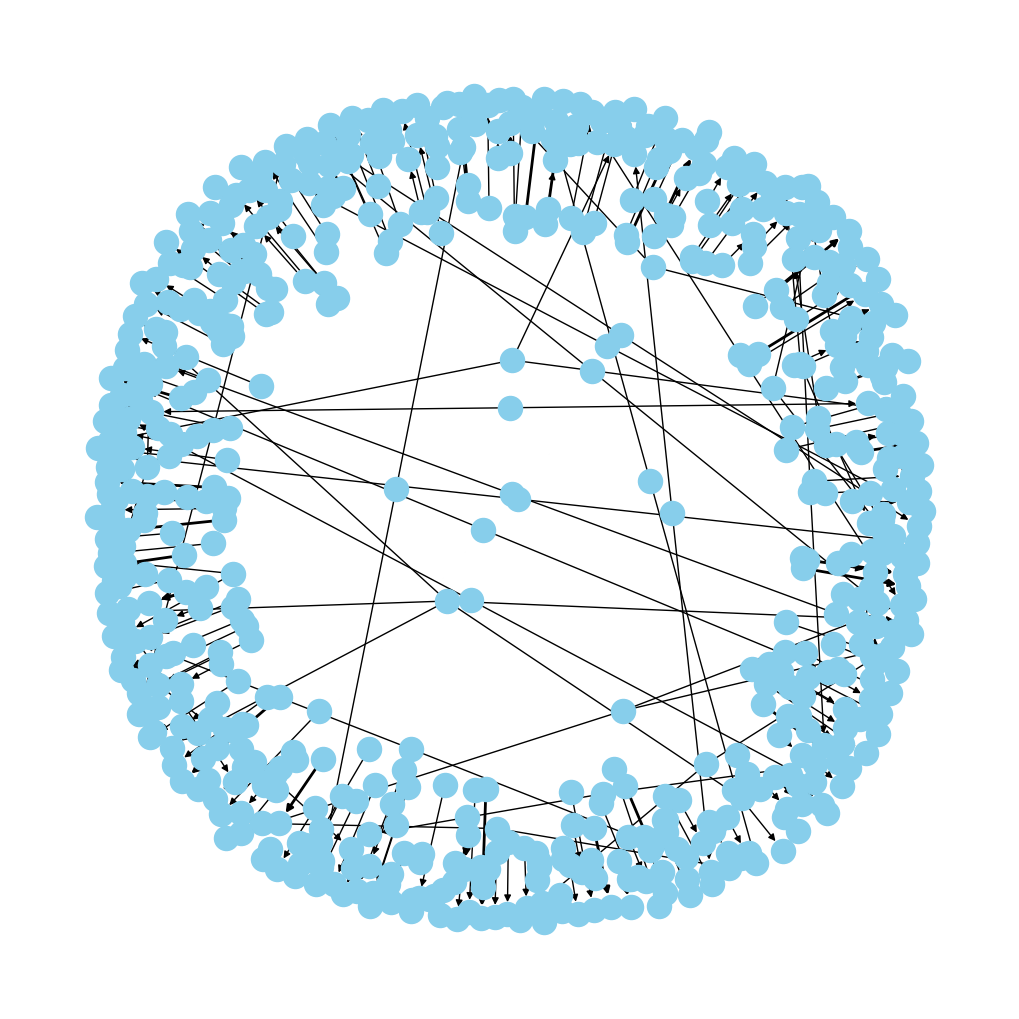

In [29]:
plotGraph(dfm_pd)

## Subset: Top 50 cited papers in Top 10 categories 

'Computer vision':'red',
'Discrete mathematics':'skyblue',
'Econometrics':'pink',
'Data science':'green',
'Social psychology': 'black', 
'Health care':'yellow',
'Computer science':'lightgreen',
'Population':'orange',
'Ontology (information science)':'grey',
'Biomedical engineering': 'brown'

In [13]:
df_graph_whole = df_subset.select('paper_id', 'category', 'doc_type', 'year', 'title', 'references', 'n_references', 'n_citation')
df_graph_whole = df_graph_whole.orderBy('n_citation', ascending = False)
# get top 50 most cited papers from each category
w = Window.partitionBy('category').orderBy(col('n_citation').desc())
# Use the rank function to get the top 50 most cited papers values for each category
top50_most_cited = df_graph_whole.select('*', rank().over(w).alias('rank')).filter(col('rank') <= 50).drop('rank')

In [31]:
top50_most_cited.show(n=10)

+--------------------+----------+----------+----+--------------------+--------------------+------------+----------+
|            paper_id|  category|  doc_type|year|               title|          references|n_references|n_citation|
+--------------------+----------+----------+----+--------------------+--------------------+------------+----------+
|573697266e3b12023...|      480p|Conference|2016|High Level Synthe...|[53e998d5b7602d97...|          21|        55|
|558a9b0ae4b0b32fc...|      480p|   Journal|1999|A flexible design...|                  []|           0|         0|
|5bbacb3717c44aecc...|      480p|Conference|2018|An End-to-End Rea...|[557c3c6c6feeaa80...|          13|         0|
|5cdbe5d7e1cd8e11d...|      480p|Conference|2018|Retargeting 4K Vi...|[53e9a351b7602d97...|           7|         0|
|53e9a0adb7602d970...|ADME Study|   Journal|2008|Drugbank: A Knowl...|[53e99aedb7602d97...|          12|      1702|
|5a9cb63417c44a376...|ADME Study|   Journal|2018|Identification of...|[5

In [32]:
top50_most_cited.count()

405547

In [33]:
top50_most_cited.select('year').describe().show()

+-------+------------------+
|summary|              year|
+-------+------------------+
|  count|            405547|
|   mean|2008.8407632161006|
| stddev| 6.733163845775771|
|    min|              1990|
|    max|              2020|
+-------+------------------+



In [14]:
top50_most_cited_filtered = top50_most_cited.filter((top50_most_cited['category']=='Computer vision') | \
                                                    (top50_most_cited['category']=='Discrete mathematics') | \
                                                    (top50_most_cited['category']=='Econometrics') | \
                                                    (top50_most_cited['category']=='Data science') | \
                                                    (top50_most_cited['category']=='Social psychology') | \
                                                    (top50_most_cited['category']=='Health care') | \
                                                    (top50_most_cited['category']=='Computer science') | \
                                                    (top50_most_cited['category']=='Population') | \
                                                    (top50_most_cited['category']=='Ontology (information science)') | \
                                                    (top50_most_cited['category']=='Biomedical engineering'))

In [36]:
top50_most_cited_filtered.count()

500

In [37]:
top50_most_cited_filtered.show(n=2, truncate=False)

+------------------------+----------------+--------+----+--------------------------------------------------------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+------------+----------+
|paper_id                |category        |doc_type|year|title                                                   |references                                                                                                                                                                                                                                                  

## Graph for 2012-2018

In [158]:
top50_most_cited_2012_2018 = top50_most_cited_filtered.filter((top50_most_cited_filtered['year'] >= 2012) & (top50_most_cited_filtered['year']<=2018))

In [159]:
# top50_most_cited_2012_2018.count()

In [160]:
df_graph_sub = top50_most_cited_2012_2018.withColumn("reference", explode(top50_most_cited_2012_2018.references)).withColumn("weight", lit(1))
dfm = df_graph_sub.groupby(df_graph_sub.paper_id,df_graph_sub.reference, df_graph_sub.category, df_graph_sub.n_references).count()
dfm = dfm[dfm['paper_id'] != dfm['reference']]
dfm = dfm.withColumnRenamed("paper_id", "src").withColumnRenamed("reference", "dst")

In [42]:
dfm.groupBy('category').count().show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|    Computer science|  522|
|        Econometrics|  179|
|   Social psychology|  187|
|     Computer vision|  386|
|Discrete mathematics|   10|
|Biomedical engine...|   34|
|         Health care|  670|
|          Population|  745|
|        Data science|  670|
|Ontology (informa...|  357|
+--------------------+-----+



In [105]:
dfm.printSchema()

root
 |-- src: string (nullable = true)
 |-- dst: string (nullable = true)
 |-- category: string (nullable = true)
 |-- n_references: integer (nullable = false)
 |-- count: long (nullable = false)



In [161]:
# join the `df` and `df_subset` DataFrames
df_joined = dfm.join(df_subset.select(col('paper_id').alias('dst_subset'), col('category').alias('dst_category')), 
             on=col('dst') == col('dst_subset'), how='left')

In [107]:
df_joined.show(n=25)

+--------------------+--------------------+--------------------+------------+-----+--------------------+--------------------+
|                 src|                 dst|            category|n_references|count|          dst_subset|        dst_category|
+--------------------+--------------------+--------------------+------------+-----+--------------------+--------------------+
|53e9b421b7602d970...|53e997b2b7602d970...|    Computer science|          16|    1|                null|                null|
|53e9ab6fb7602d970...|53e997f1b7602d970...|          Population|         153|    1|                null|                null|
|53e99876b7602d970...|53e998b0b7602d970...|        Econometrics|          10|    1|                null|                null|
|53e9aa02b7602d970...|53e99959b7602d970...|        Data science|         146|    1|53e99959b7602d970...|     Motion planning|
|53e9aa02b7602d970...|53e999d8b7602d970...|        Data science|         146|    1|53e999d8b7602d970...|    Gradient d

In [162]:
graph_data = df_joined.na.drop()
# graph_data.show(n=25)

In [163]:
graph_data_pd = graph_data.toPandas()

In [110]:
graph_data_pd

,src,dst,category,n_references,count,dst_subset,dst_category
0,53e9aa02b7602d970336ce11,53e99959b7602d97021983aa,Data science,146,1,53e99959b7602d97021983aa,Motion planning
1,53e9aa02b7602d970336ce11,53e999d8b7602d970221dee0,Data science,146,1,53e999d8b7602d970221dee0,Gradient descent
2,558ba5f684ae6766fdee74a2,53e99a49b7602d97022ab77f,Health care,100,1,53e99a49b7602d97022ab77f,Health care
3,5a260c5d17c44a4ba8a29d39,53e99a49b7602d97022ab77f,Population,59,1,53e99a49b7602d97022ab77f,Health care
4,557c7cf008b02739a5ca83ec,53e99abdb7602d970233ac88,Econometrics,37,1,53e99abdb7602d970233ac88,Social psychology
...,...,...,...,...,...,...,...
2955,5736960e6e3b12023e520c34,573696ce6e3b12023e5cea53,Computer vision,14,1,573696ce6e3b12023e5cea53,Computer science
2956,573696f46e3b12023e5f12ae,573696ce6e3b12023e5cec74,Computer vision,45,1,573696ce6e3b12023e5cec74,Pattern recognition
2957,573696056e3b12023e51921c,5736986b6e3b12023e7300c3,Computer science,57,1,5736986b6e3b12023e7300c3,Architecture
2958,5c0f77d3da562944ac72bc2c,5a260c5217c44a4ba8a28ab7,Data science,59,1,5a260c5217c44a4ba8a28ab7,Noise reduction


In [164]:
# Get the categories from the dataframe and assign a color to each category
categories = list(set(graph_data_pd['category']) | set(graph_data_pd['dst_category']))

In [112]:
len(categories)

774

In [165]:
# we only want to keep the ten selected categories- 
selected_cats = ['Computer vision', 'Discrete mathematics', 'Econometrics', 'Data science', 'Social psychology','Health care','Computer science',
                 'Population' ,'Ontology (information science)','Biomedical engineering']

In [166]:
graph_data_pd2 = graph_data_pd[graph_data_pd['dst_category'].isin(selected_cats)]

In [115]:
categories2 = list(set(graph_data_pd2['category']) | set(graph_data_pd2['dst_category']))
len(categories2)

10

In [116]:
graph_data_pd2

,src,dst,category,n_references,count,dst_subset,dst_category
2,558ba5f684ae6766fdee74a2,53e99a49b7602d97022ab77f,Health care,100,1,53e99a49b7602d97022ab77f,Health care
3,5a260c5d17c44a4ba8a29d39,53e99a49b7602d97022ab77f,Population,59,1,53e99a49b7602d97022ab77f,Health care
4,557c7cf008b02739a5ca83ec,53e99abdb7602d970233ac88,Econometrics,37,1,53e99abdb7602d970233ac88,Social psychology
13,558c4a2384ae6766fdf2358f,53e9a163b7602d9702a57d5e,Computer vision,39,1,53e9a163b7602d9702a57d5e,Computer vision
17,53e9a7bab7602d97030f3fb7,53e9a5e9b7602d9702f13cea,Social psychology,18,1,53e9a5e9b7602d9702f13cea,Social psychology
...,...,...,...,...,...,...,...
2940,53e9b8d4b7602d97044b8676,53e9baf6b7602d9704727d92,Ontology (information science),30,2,53e9baf6b7602d9704727d92,Ontology (information science)
2942,53e99884b7602d97020bc30e,53e9bd9fb7602d9704a4b6e4,Ontology (information science),26,1,53e9bd9fb7602d9704a4b6e4,Computer science
2951,573696056e3b12023e51921c,558ae41ce4b0b32fcb397d72,Computer science,57,1,558ae41ce4b0b32fcb397d72,Computer vision
2955,5736960e6e3b12023e520c34,573696ce6e3b12023e5cea53,Computer vision,14,1,573696ce6e3b12023e5cea53,Computer science


In [167]:
# Create an empty graph
G = nx.Graph()
# Iterate over the rows of the dataframe
for index, row in graph_data_pd2.iterrows():
    # Add the source node to the graph with its category as node attribute
    G.add_node(row['src'], category=row['category'])
    # Add the destination node to the graph with its category as node attribute
    G.add_node(row['dst'], category=row['dst_category'])
    # Add an edge between the source and destination nodes
    G.add_edge(row['src'], row['dst'], weight=1)
    
# Create a dictionary to map category to color
# color_map = dict(zip(categories, colors[:len(categories)]))
color_map = {'Computer vision':'red',
                     'Discrete mathematics':'skyblue',
                     'Econometrics':'pink',
                     'Data science':'green',
                     'Social psychology': 'black', 
                     'Health care':'yellow',
                     'Computer science':'lightgreen',
                     'Population':'orange',
                     'Ontology (information science)':'grey',
                     'Biomedical engineering': 'brown'}

# Get the node colors based on the category attribute
node_colors = [color_map[G.nodes[n]['category']] for n in G.nodes()]

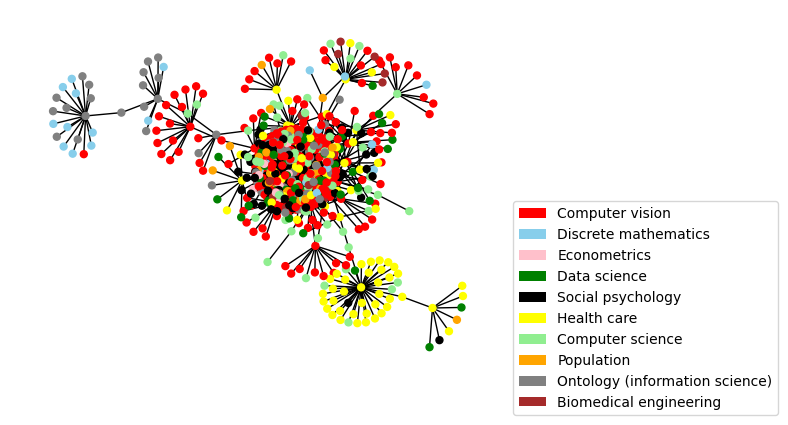

In [168]:
# Draw the graph with node and edge colors, and a legend for node colors
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=25)
nx.draw_networkx_edges(G, pos)
plt.axis('off')
plt.legend([plt.Circle((0,0), 1, fc=color) for color in color_map.values()], color_map.keys(), loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

## Graph for 1995-2002

In [169]:
top50_most_cited_2012_2018 = top50_most_cited_filtered.filter((top50_most_cited_filtered['year'] >= 1995) & (top50_most_cited_filtered['year']<=2002))
df_graph_sub = top50_most_cited_2012_2018.withColumn("reference", explode(top50_most_cited_2012_2018.references)).withColumn("weight", lit(1))
dfm = df_graph_sub.groupby(df_graph_sub.paper_id,df_graph_sub.reference, df_graph_sub.category).count()
dfm = dfm[dfm['paper_id'] != dfm['reference']]
dfm = dfm.withColumnRenamed("paper_id", "src").withColumnRenamed("reference", "dst")
# join the `df` and `df_subset` DataFrames
df_joined = dfm.join(df_subset.select(col('paper_id').alias('dst_subset'), col('category').alias('dst_category')), 
             on=col('dst') == col('dst_subset'), how='left')
graph_data = df_joined.na.drop()
graph_data_pd = graph_data.toPandas()

In [95]:
# Get the categories from the dataframe and assign a color to each category
categories = list(set(graph_data_pd['category']) | set(graph_data_pd['dst_category']))
len(categories)

415

In [170]:
# we only want to keep the ten selected categories- 
selected_cats = ['Computer vision', 'Discrete mathematics', 'Econometrics', 'Data science', 'Social psychology','Health care','Computer science',
                 'Population' ,'Ontology (information science)','Biomedical engineering']
graph_data_pd2 = graph_data_pd[graph_data_pd['dst_category'].isin(selected_cats)]
categories2 = list(set(graph_data_pd2['category']) | set(graph_data_pd2['dst_category']))
len(categories2)

10

In [171]:
# Create an empty graph
G = nx.Graph()
# Iterate over the rows of the dataframe
for index, row in graph_data_pd2.iterrows():
    # Add the source node to the graph with its category as node attribute
    G.add_node(row['src'], category=row['category'])
    # Add the destination node to the graph with its category as node attribute
    G.add_node(row['dst'], category=row['dst_category'])
    # Add an edge between the source and destination nodes
    G.add_edge(row['src'], row['dst'], weight=1)
    
# Create a dictionary to map category to color
# color_map = dict(zip(categories, colors[:len(categories)]))
color_map = {'Computer vision':'red',
                     'Discrete mathematics':'skyblue',
                     'Econometrics':'pink',
                     'Data science':'green',
                     'Social psychology': 'black', 
                     'Health care':'yellow',
                     'Computer science':'lightgreen',
                     'Population':'orange',
                     'Ontology (information science)':'grey',
                     'Biomedical engineering': 'brown'}

# Get the node colors based on the category attribute
node_colors = [color_map[G.nodes[n]['category']] for n in G.nodes()]

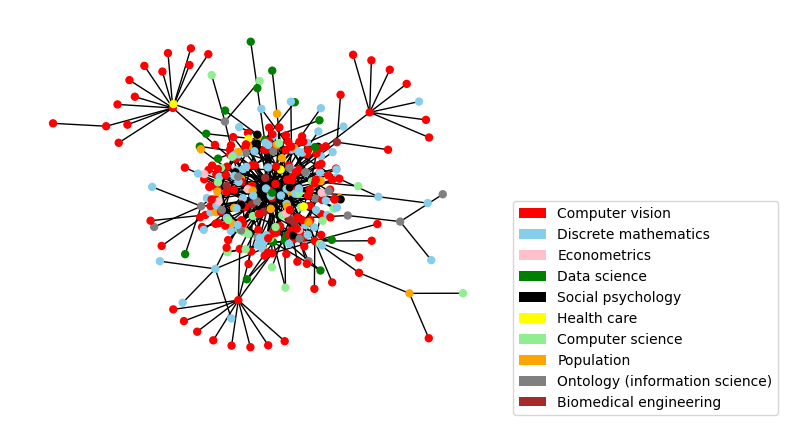

In [172]:
# Draw the graph with node and edge colors, and a legend for node colors
pos = nx.kamada_kawai_layout(G)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=25)
nx.draw_networkx_edges(G, pos)
plt.figure(1,figsize=(15,15)) 
plt.axis('off')
plt.legend([plt.Circle((0,0), 1, fc=color) for color in color_map.values()], color_map.keys(), loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

## Graph for 2003-2011

In [25]:
top50_most_cited_2012_2018 = top50_most_cited_filtered.filter((top50_most_cited_filtered['year'] >= 2003) & (top50_most_cited_filtered['year']<=2011))
df_graph_sub = top50_most_cited_2012_2018.withColumn("reference", explode(top50_most_cited_2012_2018.references)).withColumn("weight", lit(1))
dfm = df_graph_sub.groupby(df_graph_sub.paper_id,df_graph_sub.reference, df_graph_sub.category, df_graph_sub.n_references).count()
dfm = dfm[dfm['paper_id'] != dfm['reference']]
dfm = dfm.withColumnRenamed("paper_id", "src").withColumnRenamed("reference", "dst")
# join the `df` and `df_subset` DataFrames
df_joined = dfm.join(df_subset.select(col('paper_id').alias('dst_subset'), col('category').alias('dst_category')), 
             on=col('dst') == col('dst_subset'), how='left')
graph_data = df_joined.na.drop()
graph_data_pd = graph_data.toPandas()

In [146]:
# Get the categories from the dataframe and assign a color to each category
categories = list(set(graph_data_pd['category']) | set(graph_data_pd['dst_category']))
len(categories)

968

In [26]:
# we only want to keep the ten selected categories- 
selected_cats = ['Computer vision', 'Discrete mathematics', 'Econometrics', 'Data science', 'Social psychology','Health care','Computer science',
                 'Population' ,'Ontology (information science)','Biomedical engineering']
graph_data_pd2 = graph_data_pd[graph_data_pd['dst_category'].isin(selected_cats)]
categories2 = list(set(graph_data_pd2['category']) | set(graph_data_pd2['dst_category']))
len(categories2)

10

In [27]:
# Create an empty graph
G = nx.Graph()
# Create a dictionary to store the positions of the nodes with highest n_references in each category
pos_dict = {}
# Iterate over the rows of the dataframe
for index, row in graph_data_pd2.iterrows():
    # Add the source node to the graph with its category as node attribute
    G.add_node(row['src'], category=row['category'])
    # Add the destination node to the graph with its category as node attribute
    G.add_node(row['dst'], category=row['dst_category'])
    # Add an edge between the source and destination nodes
    G.add_edge(row['src'], row['dst'], weight=1)
    # Check if the current row has the highest n_references within its category
    if row['category'] not in pos_dict or row['n_references'] > graph_data_pd2.loc[pos_dict[row['category']], 'n_references']:
        pos_dict[row['category']] = index
    
# Create a dictionary to map category to color
# color_map = dict(zip(categories, colors[:len(categories)]))
color_map = {'Computer vision':'red',
                     'Discrete mathematics':'skyblue',
                     'Econometrics':'pink',
                     'Data science':'green',
                     'Social psychology': 'black', 
                     'Health care':'yellow',
                     'Computer science':'lightgreen',
                     'Population':'orange',
                     'Ontology (information science)':'grey',
                     'Biomedical engineering': 'brown'}

# Get the node colors based on the category attribute
node_colors = [color_map[G.nodes[n]['category']] for n in G.nodes()]

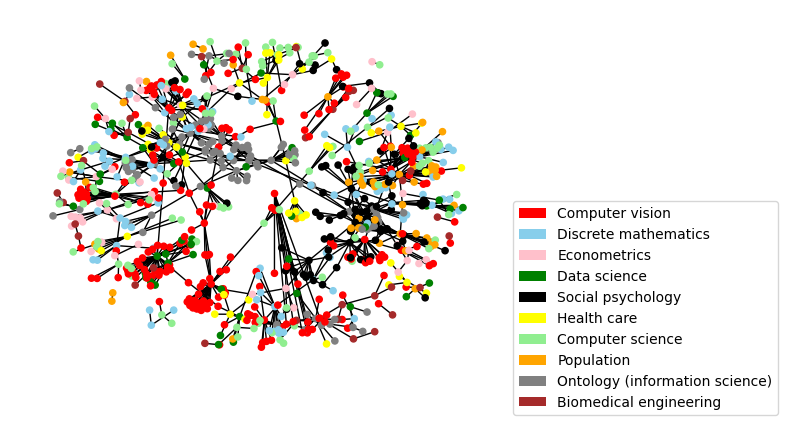

In [35]:
# Draw the graph with node and edge colors, and a legend for node colors
# pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, k = 0.1)
# normalize the pos_index dict
# Calculate the sum of all values
total = 0
for x in pos_dict.values():
    total +=  x
pos_dict = {k: v / total for k, v in pos_dict.items()}
for category, index in pos_dict.items():
    pos[row['src']] = (index * 1.2, index * 0.1)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=20)
nx.draw_networkx_edges(G, pos)
plt.figure(1,figsize=(15,15)) 
plt.axis('off')
plt.legend([plt.Circle((0,0), 1, fc=color) for color in color_map.values()], color_map.keys(), loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

In [29]:
pos_dict

{'Econometrics': 471,
 'Discrete mathematics': 87,
 'Population': 13,
 'Ontology (information science)': 179,
 'Computer vision': 104,
 'Biomedical engineering': 1312,
 'Social psychology': 334,
 'Health care': 43,
 'Data science': 298,
 'Computer science': 176}

## Graph for 2017-18

In [16]:
top50_most_cited_2017_2018 = top50_most_cited_filtered.filter((top50_most_cited_filtered['year'] >= 2017) & (top50_most_cited_filtered['year']<=2018))
df_graph_sub = top50_most_cited_2017_2018.withColumn("reference", explode(top50_most_cited_2017_2018.references)).withColumn("weight", lit(1))
dfm = df_graph_sub.groupby(df_graph_sub.paper_id,df_graph_sub.reference, df_graph_sub.category, df_graph_sub.n_references).count()
dfm = dfm[dfm['paper_id'] != dfm['reference']]
dfm = dfm.withColumnRenamed("paper_id", "src").withColumnRenamed("reference", "dst")
# join the `df` and `df_subset` DataFrames
df_joined = dfm.join(df_subset.select(col('paper_id').alias('dst_subset'), col('category').alias('dst_category')), 
             on=col('dst') == col('dst_subset'), how='left')
graph_data = df_joined.na.drop()
graph_data_pd = graph_data.toPandas()
# we only want to keep the ten selected categories- 
selected_cats = ['Computer vision', 'Discrete mathematics', 'Econometrics', 'Data science', 'Social psychology','Health care','Computer science',
                 'Population' ,'Ontology (information science)','Biomedical engineering']
graph_data_pd2 = graph_data_pd[graph_data_pd['dst_category'].isin(selected_cats)]

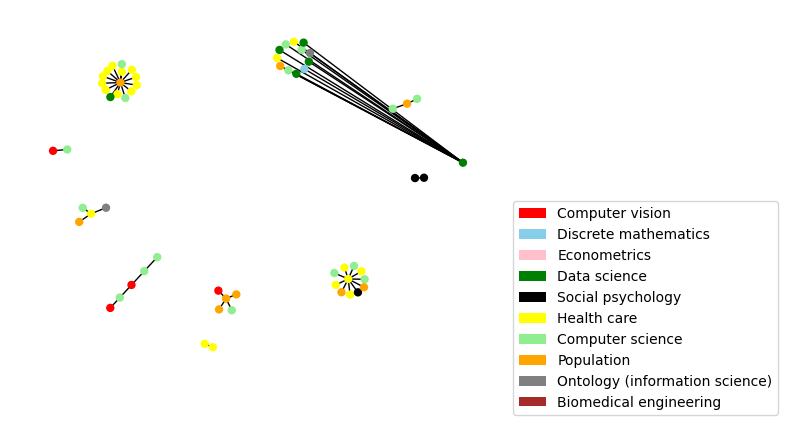

In [24]:
# Create an empty graph
G = nx.Graph()
# Create a dictionary to store the positions of the nodes with highest n_references in each category
pos_dict = {}
# Iterate over the rows of the dataframe
for index, row in graph_data_pd2.iterrows():
    # Add the source node to the graph with its category as node attribute
    G.add_node(row['src'], category=row['category'])
    # Add the destination node to the graph with its category as node attribute
    G.add_node(row['dst'], category=row['dst_category'])
    # Add an edge between the source and destination nodes
    G.add_edge(row['src'], row['dst'], weight=1)
#      Check if the current row has the highest n_references within its category
    if row['category'] not in pos_dict or row['n_references'] > graph_data_pd2.loc[pos_dict[row['category']], 'n_references']:
        pos_dict[row['category']] = index
    
# Create a dictionary to map category to color
# color_map = dict(zip(categories, colors[:len(categories)]))
color_map = {'Computer vision':'red',
                     'Discrete mathematics':'skyblue',
                     'Econometrics':'pink',
                     'Data science':'green',
                     'Social psychology': 'black', 
                     'Health care':'yellow',
                     'Computer science':'lightgreen',
                     'Population':'orange',
                     'Ontology (information science)':'grey',
                     'Biomedical engineering': 'brown'}

# Get the node colors based on the category attribute
node_colors = [color_map[G.nodes[n]['category']] for n in G.nodes()]
# Draw the graph with node and edge colors, and a legend for node colors
# pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G)
# normalize the pos_index dict
# Calculate the sum of all values
total = 0
for x in pos_dict.values():
    total +=  x
pos_dict = {k: v / total for k, v in pos_dict.items()}
for category, index in pos_dict.items():
    pos[row['src']] = (1.2, index * 0.1)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=25)
nx.draw_networkx_edges(G, pos)
plt.figure(1,figsize=(15,15)) 
plt.axis('off')
plt.legend([plt.Circle((0,0), 1, fc=color) for color in color_map.values()], color_map.keys(), loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

## Graph for 2010- 2011

In [36]:
top50_most_cited_2010_2011 = top50_most_cited_filtered.filter((top50_most_cited_filtered['year'] >= 2010) & (top50_most_cited_filtered['year']<=2011))
df_graph_sub = top50_most_cited_2010_2011.withColumn("reference", explode(top50_most_cited_2010_2011.references)).withColumn("weight", lit(1))
dfm = df_graph_sub.groupby(df_graph_sub.paper_id,df_graph_sub.reference, df_graph_sub.category, df_graph_sub.n_references).count()
dfm = dfm[dfm['paper_id'] != dfm['reference']]
dfm = dfm.withColumnRenamed("paper_id", "src").withColumnRenamed("reference", "dst")
# join the `df` and `df_subset` DataFrames
df_joined = dfm.join(df_subset.select(col('paper_id').alias('dst_subset'), col('category').alias('dst_category')), 
             on=col('dst') == col('dst_subset'), how='left')
graph_data = df_joined.na.drop()
graph_data_pd = graph_data.toPandas()
# we only want to keep the ten selected categories- 
selected_cats = ['Computer vision', 'Discrete mathematics', 'Econometrics', 'Data science', 'Social psychology','Health care','Computer science',
                 'Population' ,'Ontology (information science)','Biomedical engineering']
graph_data_pd2 = graph_data_pd[graph_data_pd['dst_category'].isin(selected_cats)]

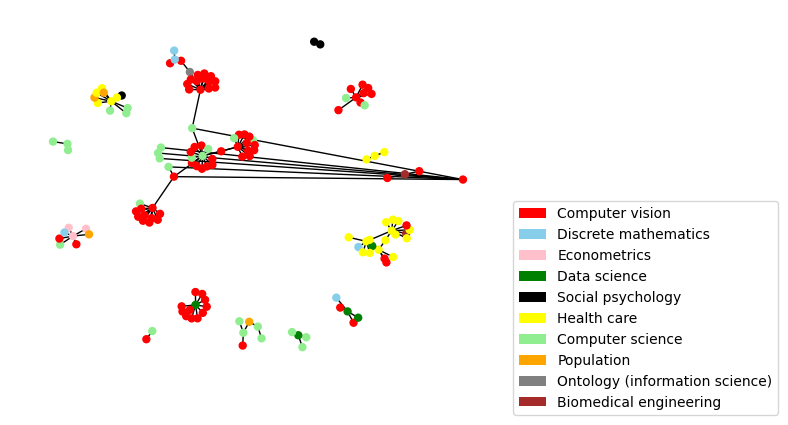

In [46]:
# Create an empty graph
G = nx.Graph()
# Create a dictionary to store the positions of the nodes with highest n_references in each category
pos_dict = {}
# Iterate over the rows of the dataframe
for index, row in graph_data_pd2.iterrows():
    # Add the source node to the graph with its category as node attribute
    G.add_node(row['src'], category=row['category'])
    # Add the destination node to the graph with its category as node attribute
    G.add_node(row['dst'], category=row['dst_category'])
    # Add an edge between the source and destination nodes
    G.add_edge(row['src'], row['dst'], weight=1)
#      Check if the current row has the highest n_references within its category
    if row['category'] not in pos_dict or row['n_references'] > graph_data_pd2.loc[pos_dict[row['category']], 'n_references']:
        pos_dict[row['category']] = index
    
# Create a dictionary to map category to color
# color_map = dict(zip(categories, colors[:len(categories)]))
color_map = {'Computer vision':'red',
                     'Discrete mathematics':'skyblue',
                     'Econometrics':'pink',
                     'Data science':'green',
                     'Social psychology': 'black', 
                     'Health care':'yellow',
                     'Computer science':'lightgreen',
                     'Population':'orange',
                     'Ontology (information science)':'grey',
                     'Biomedical engineering': 'brown'}

# Get the node colors based on the category attribute
node_colors = [color_map[G.nodes[n]['category']] for n in G.nodes()]
# Draw the graph with node and edge colors, and a legend for node colors
# pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, k = 0.1)
# normalize the pos_index dict
# Calculate the sum of all values
total = 0
for x in pos_dict.values():
    total +=  x
pos_dict = {k: v / total for k, v in pos_dict.items()}
for category, index in pos_dict.items():
    pos[row['src']] = (1.2, index * 0.1)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=25)
nx.draw_networkx_edges(G, pos)
plt.figure(1,figsize=(15,15)) 
plt.axis('off')
plt.legend([plt.Circle((0,0), 1, fc=color) for color in color_map.values()], color_map.keys(), loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

## Graph for 2000-2001

In [39]:
top50_most_cited_2000_2001 = top50_most_cited_filtered.filter((top50_most_cited_filtered['year'] >= 2000) & (top50_most_cited_filtered['year']<=2001))
df_graph_sub = top50_most_cited_2000_2001.withColumn("reference", explode(top50_most_cited_2000_2001.references)).withColumn("weight", lit(1))
dfm = df_graph_sub.groupby(df_graph_sub.paper_id,df_graph_sub.reference, df_graph_sub.category, df_graph_sub.n_references).count()
dfm = dfm[dfm['paper_id'] != dfm['reference']]
dfm = dfm.withColumnRenamed("paper_id", "src").withColumnRenamed("reference", "dst")
# join the `df` and `df_subset` DataFrames
df_joined = dfm.join(df_subset.select(col('paper_id').alias('dst_subset'), col('category').alias('dst_category')), 
             on=col('dst') == col('dst_subset'), how='left')
graph_data = df_joined.na.drop()
graph_data_pd = graph_data.toPandas()
# we only want to keep the ten selected categories- 
selected_cats = ['Computer vision', 'Discrete mathematics', 'Econometrics', 'Data science', 'Social psychology','Health care','Computer science',
                 'Population' ,'Ontology (information science)','Biomedical engineering']
graph_data_pd2 = graph_data_pd[graph_data_pd['dst_category'].isin(selected_cats)]

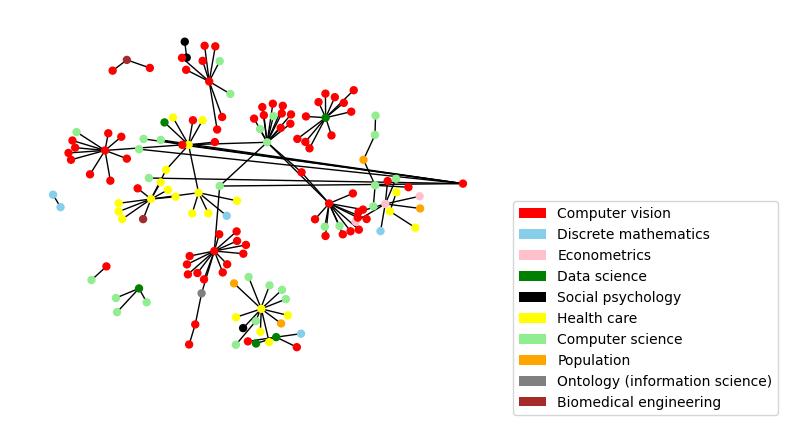

In [44]:
# Create an empty graph
G = nx.Graph()
# Create a dictionary to store the positions of the nodes with highest n_references in each category
pos_dict = {}
# Iterate over the rows of the dataframe
for index, row in graph_data_pd2.iterrows():
    # Add the source node to the graph with its category as node attribute
    G.add_node(row['src'], category=row['category'])
    # Add the destination node to the graph with its category as node attribute
    G.add_node(row['dst'], category=row['dst_category'])
    # Add an edge between the source and destination nodes
    G.add_edge(row['src'], row['dst'], weight=1)
#      Check if the current row has the highest n_references within its category
    if row['category'] not in pos_dict or row['n_references'] > graph_data_pd2.loc[pos_dict[row['category']], 'n_references']:
        pos_dict[row['category']] = index
    
# Create a dictionary to map category to color
# color_map = dict(zip(categories, colors[:len(categories)]))
color_map = {'Computer vision':'red',
                     'Discrete mathematics':'skyblue',
                     'Econometrics':'pink',
                     'Data science':'green',
                     'Social psychology': 'black', 
                     'Health care':'yellow',
                     'Computer science':'lightgreen',
                     'Population':'orange',
                     'Ontology (information science)':'grey',
                     'Biomedical engineering': 'brown'}

# Get the node colors based on the category attribute
node_colors = [color_map[G.nodes[n]['category']] for n in G.nodes()]
# Draw the graph with node and edge colors, and a legend for node colors
# pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, k = 0.1)
# normalize the pos_index dict
# Calculate the sum of all values
total = 0
for x in pos_dict.values():
    total +=  x
pos_dict = {k: v / total for k, v in pos_dict.items()}
for category, index in pos_dict.items():
    pos[row['src']] = (1.2, index * 0.1)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=25)
nx.draw_networkx_edges(G, pos)
plt.figure(1,figsize=(15,15)) 
plt.axis('off')
plt.legend([plt.Circle((0,0), 1, fc=color) for color in color_map.values()], color_map.keys(), loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

## Graph for 2015-17

In [48]:
top50_most_cited_2015_20017 = top50_most_cited_filtered.filter((top50_most_cited_filtered['year'] >= 2016) & (top50_most_cited_filtered['year']<=2018))
df_graph_sub = top50_most_cited_2015_20017.withColumn("reference", explode(top50_most_cited_2015_20017.references)).withColumn("weight", lit(1))
dfm = df_graph_sub.groupby(df_graph_sub.paper_id,df_graph_sub.reference, df_graph_sub.category, df_graph_sub.n_references).count()
dfm = dfm[dfm['paper_id'] != dfm['reference']]
dfm = dfm.withColumnRenamed("paper_id", "src").withColumnRenamed("reference", "dst")
# join the `df` and `df_subset` DataFrames
df_joined = dfm.join(df_subset.select(col('paper_id').alias('dst_subset'), col('category').alias('dst_category')), 
             on=col('dst') == col('dst_subset'), how='left')
graph_data = df_joined.na.drop()
graph_data_pd = graph_data.toPandas()
# we only want to keep the ten selected categories- 
selected_cats = ['Computer vision', 'Discrete mathematics', 'Econometrics', 'Data science', 'Social psychology','Health care','Computer science',
                 'Population' ,'Ontology (information science)','Biomedical engineering']
graph_data_pd2 = graph_data_pd[graph_data_pd['dst_category'].isin(selected_cats)]

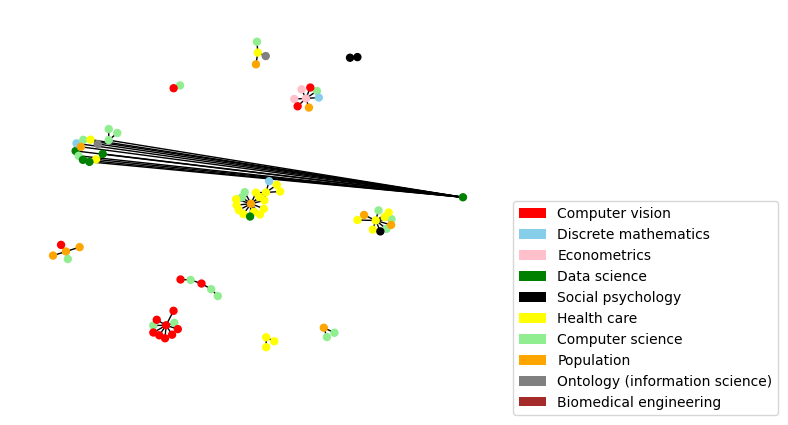

In [52]:
# Create an empty graph
G = nx.Graph()
# Create a dictionary to store the positions of the nodes with highest n_references in each category
pos_dict = {}
# Iterate over the rows of the dataframe
for index, row in graph_data_pd2.iterrows():
    # Add the source node to the graph with its category as node attribute
    G.add_node(row['src'], category=row['category'])
    # Add the destination node to the graph with its category as node attribute
    G.add_node(row['dst'], category=row['dst_category'])
    # Add an edge between the source and destination nodes
    G.add_edge(row['src'], row['dst'], weight=1)
#      Check if the current row has the highest n_references within its category
    if row['category'] not in pos_dict or row['n_references'] > graph_data_pd2.loc[pos_dict[row['category']], 'n_references']:
        pos_dict[row['category']] = index
    
# Create a dictionary to map category to color
# color_map = dict(zip(categories, colors[:len(categories)]))
color_map = {'Computer vision':'red',
                     'Discrete mathematics':'skyblue',
                     'Econometrics':'pink',
                     'Data science':'green',
                     'Social psychology': 'black', 
                     'Health care':'yellow',
                     'Computer science':'lightgreen',
                     'Population':'orange',
                     'Ontology (information science)':'grey',
                     'Biomedical engineering': 'brown'}

# Get the node colors based on the category attribute
node_colors = [color_map[G.nodes[n]['category']] for n in G.nodes()]
# Draw the graph with node and edge colors, and a legend for node colors
# pos = nx.kamada_kawai_layout(G)
pos = nx.spring_layout(G, k = 0.1)
# normalize the pos_index dict
# Calculate the sum of all values
total = 0
for x in pos_dict.values():
    total +=  x
pos_dict = {k: v / total for k, v in pos_dict.items()}
for category, index in pos_dict.items():
    pos[row['src']] = (1.2, index * 0.1)
nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=25)
nx.draw_networkx_edges(G, pos)
plt.figure(1,figsize=(15,15)) 
plt.axis('off')
plt.legend([plt.Circle((0,0), 1, fc=color) for color in color_map.values()], color_map.keys(), loc='best', bbox_to_anchor=(1, 0.5))
plt.show()

## References

* https://sparkbyexamples.com/spark/spark-get-size-length-of-array-map-column/
* https://stackoverflow.com/questions/65483515/how-to-create-edge-list-from-spark-data-frame-in-pyspark
* https://www.youtube.com/watch?v=SiXjTkGFwng
* https://stackoverflow.com/questions/27965295/dropping-rows-from-dataframe-based-on-a-not-in-condition
* https://stackoverflow.com/questions/30035039/fix-position-of-subset-of-nodes-in-networkx-spring-graph
* https://github.com/KangboLu/Graph-Analysis-with-NetworkX/blob/main/02_graph_layouts_spring_layout.ipynb
